# <center> Euristiche Local Search e Tabu Search per Set Covering Problem </center> #

| Cognome | Nome | Matricola |
| :-: | :-: | :-: |
| Fazzari | Daniele | M63001384 |
| Conte | Alfonso | M63001378 |

## <center>Set Covering Problem</center>

Il problema del set covering è un particolare problema di **selezione di sottoinsiemi (Subsets $S_j$**) nel quale si vuole garantire che ogni elemento appartenente all'insieme degli elementi da "coprire" (con i subsets) sia "coperto" da almeno un subset. Dunque, a differenza dei problemi di Set Partitioning e Set Packing, il generico elemento i-esimo può essere coperto da (o equivalentemente può "appartenere" a) più subset **$S_j \in Sol$** (Sol è una generica soluzione del problema).

Sia **A** la **matrice di copertura** (di dimensioni **mxn**, dove "m" è il numero di elementi da coprire ed "n" il numero di subsets) il cui generico elemento **$a_{ij}$** è definito come segue:

- **1** se i $\in S_j$ </center>
- **0** altrimenti
    
Sia **x** il **vettore delle variabili** binarie (una per ogni subset $S_j$) la cui componente j-esima **$x_j$** è definita come segue:
- **1** se $S_j \in$ Sol
- 0 altrimenti

Sia **c** il **vettore dei costi** il cui elemento j-esimo **$c_j$** rappresenta il costo associato alla scelta del subset $S_j$. Esso risulta necessario alla definizione della **funzione obiettivo**, ovvero la minimizzazione del costo complessivo della soluzione: 

\begin{equation}
\sum_{j \in n} c_j x_j 
\end{equation}

Dunque è possibile formulare un problema di Set Covering nella seguente maniera compatta:

\begin{equation}
min \;\; c^{T} x \\
A x \geq 1 \\
x \in \{0,1\}^n \\
\end{equation}

## <center> Risoluzione all'ottimo (Gurobi) </center>

Importazione degli elementi di libreria di **Gurobi Optimizer** utili alla definizione del modello e alla risoluzione del problema (GRB), importazione della libreria numpy per l'algebra lineare. I dati del problema sono contenuti in un file di testo che deve essere essere opportunamente aperto (funzione open) e interpretato successivamente.

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time 
import matplotlib.pyplot as plt
import math 

In [2]:
filename_1 = "tdp1.txt"
filename_2 = "scp41.txt"
filename_3 = "scp51.txt"
file = open(filename_3) 

### <center> Definizione del modello </center>

Lettura delle dimensioni m (num_righe) e n (num_colonne) della matrice di copertura A e degli elementi $a_ij$ (letti ed inseriti in una lista di interi) usati per popolarla. Definizione del vettore dei costi associati ai subsets.

In [3]:
linea= file.readline() 
riga_0=linea.split()
num_righe=int(riga_0[0]) 
num_colonne=int(riga_0[1]) 

Dati = []  
while True:
    linea = file.readline().split()
    if not linea: #data==null-->EOF
        break
    for i in range(len(linea)):
        Dati.append(int(linea[i]))
        
costi_Sj = []  
for i in range(num_colonne):
    costi_Sj.append(Dati[i]) 
    
A = np.zeros((num_righe, num_colonne))
#indice da cui partire a leggere Dati 
#(num colonne che coprono la riga 0)
start_index = num_colonne 

for i in range(num_righe): 
    num_coperture = Dati[start_index]
    start_index = start_index + 1
    for j in range(num_coperture):
         #1 in corrispondenza dei Subset Sj che coprono la riga i-esima
        A[i][Dati[start_index+j]-1]=1
    #indice del numero di coperture per la successiva riga
    start_index = start_index+num_coperture 

Inizializzazione del modello, creazione delle **variabili decisionali** $x_j$ del problema, definizione della **funzione obiettivo** e aggiunta dei constraints del problema.

In [4]:
#Inizializzazione modello 
mod = gp.Model('SetCoveringOttimo')

#vettore variabili decisionali
num_Xvars=range(num_colonne)
Xvars= mod.addVars(num_Xvars, name='X', vtype=GRB.BINARY)

#Funzione obiettivo
obj = gp.quicksum(costi_Sj[i]*Xvars[i] for i in num_Xvars) 
mod.setObjective(obj, GRB.MINIMIZE)

#Vincoli del problema
A=A.tolist()
Constr= mod.addConstrs((Xvars.prod(A[i])>=1 for i in range(num_righe)))

### <center> Risoluzione ottima </center>

**Risoluzione all'ottimo** del problema (appena modellato) utilizzando il modulo **optimize**, con conseguente print della (o di una) soluzione ottima (nel caso in cui sia stata trovata)

In [5]:
mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 200 rows, 2000 columns and 7995 nonzeros
Model fingerprint: 0x3867c20a
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6643.0000000
Presolve removed 3 rows and 1797 columns
Presolve time: 0.03s
Presolved: 197 rows, 203 columns, 1000 nonzeros
Found heuristic solution: objective 261.0000000
Variable types: 0 continuous, 203 integer (203 binary)

Root relaxation: objective 2.512250e+02, 227 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  251.22500    0   58  261.00000  251.22500 

In [6]:
if mod.status == GRB.OPTIMAL:
    foundOptimalSol = True
    Valore_Ottimo=mod.objVal
    print('Valore soluzione: %g' % Valore_Ottimo)
    X = mod.getAttr('x', Xvars)
    print(type(X))
    PrintX = np.zeros(num_colonne)
    #for i in num_Xvars:
        #if X[i] > 0 :
        #print('X(%s) = %g' % (i, X[i]) )
    print("Soluzione: ", X)

Valore soluzione: 253
<class 'gurobipy.tupledict'>
Soluzione:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 0.0, 8: -0.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 0.0, 15: 1.0, 16: -0.0, 17: 1.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: -0.0, 22: -0.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: -0.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 0.0, 36: 1.0, 37: -0.0, 38: 0.0, 39: 0.0, 40: -0.0, 41: 1.0, 42: 1.0, 43: 0.0, 44: 1.0, 45: 0.0, 46: 1.0, 47: 1.0, 48: 0.0, 49: 1.0, 50: 1.0, 51: 0.0, 52: -0.0, 53: -0.0, 54: 0.0, 55: -0.0, 56: 1.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 1.0, 61: -0.0, 62: 0.0, 63: 0.0, 64: 1.0, 65: -0.0, 66: -0.0, 67: 0.0, 68: 1.0, 69: -0.0, 70: -0.0, 71: 1.0, 72: -0.0, 73: 1.0, 74: 1.0, 75: 1.0, 76: 1.0, 77: 0.0, 78: 0.0, 79: 1.0, 80: 1.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 1.0, 85: 1.0, 86: 1.0, 87: 1.0, 88: 0.0, 89: 0.0, 90: 1.0, 91: 0.0, 92: -0.0, 93: -0.0, 94: -0.0, 95: -0.0, 96: -0.0, 97: 0.0, 98: -0.0, 99: 0.0, 100: -0.0, 101: 0.0, 102

## <center> Risoluzione con Euristica Local Search </center>

### <center> Funzioni di utilità </center>

Funzione per determinazione di una soluzione ammissibile. Restituisce True se la soluzione (la quale ha associata il vettore di copertura righe in ingresso) è ammissibile per il problema di set covering considerato, False altrimenti. 
( NOTA: il nome deriva dal fatto che è utilizzata dall'algoritmo greedy )

In [7]:
def is_a_solution_greedy(righe_coperte):
    somma=np.sum(righe_coperte)
    if somma == len(righe_coperte): 
        return True
    else:
        return False

Funzione per determinazione di una soluzione ammissibile a partire dal vettore di copertura delle righe. Restituisce False se è trovata una riga  non coperta (aka un elemento non coperto)

In [8]:
def is_a_solution(righe_coperte, num_righe): 
    for i in range(num_righe):
        if righe_coperte[i]==0:
            return False
    return True

Funzione per valutare la copertura delle righe. Restituisce una lista il 
cui elemento i-esimo è il numero di subset Sj che coprono l'elemento i (ovvero la riga i)

In [9]:
def copri_righe(Sol,A, num_righe, num_colonne):
    righe_coperte = np.zeros(num_righe)
    for i in range(num_colonne):
        if(Sol[i]==1):
            for j in range(num_righe):
                if A[j][i]==1:
                    righe_coperte[j]+=1
    return righe_coperte

Definizione funzioni per aggiustamento del vettore di copertura delle righe in caso di eliminazione, aggiunta e swap di righe (aka elementi)

In [10]:
def delete_righe_coperte(righe_coperte,k,A,num_righe):
    righe_coperte_delete = np.zeros(num_righe)
    for i in range(num_righe):
        righe_coperte_delete[i] = righe_coperte[i]
        if A[i][k]==1:
            righe_coperte_delete[i]-=1
    return righe_coperte_delete
            
def swap_righe_coperte(righe_coperte,h,k,A,num_righe):
    righe_coperte_swap = np.zeros(num_righe)
    for i in range(num_righe):
        righe_coperte_swap[i]=righe_coperte[i]
        if A[i][h]==1:
            righe_coperte_swap[i]-=1
        if A[i][k]==1:
            righe_coperte_swap[i]+=1
    return righe_coperte_swap

def add_righe_coperte(righe_coperte,k,A,num_righe):
    righe_coperte_delete=np.zeros(num_righe)
    for i in range(num_righe):
        righe_coperte_delete[i]=righe_coperte[i]
        if A[i][k]==1:
            righe_coperte_delete[i]+=1
    return righe_coperte_delete

Definizione funzione per aggiunta alla soluzione del subset Sj con il minore rapporto costo/copertura. Il parametro min_index è di uscita, rappresenta l'indice del subset con il rapporto costo/copertura minore

In [11]:
def aggiungi_set_migliore(Sol,costi_Sj,coperture_Sj,min_index, num_colonne):
    costi=np.zeros(num_colonne)
    costi_copertura=np.zeros(num_colonne)
    for i in range(num_colonne):
        if Sol[i]==0:
            costi_copertura[i]=costi_Sj[i]/coperture_Sj[i]
    min_index=costi_copertura.tolist().index(np.min(costi_copertura[np.nonzero(costi_copertura)]))
    Sol[min_index]=1

Definizione funzione per il calcolo del valore di una soluzione, fornito il vettore soluzione e il vettore dei costi dei subset (costi_Sj)

In [12]:
def val_sol(Sol,costi_Sj):
    val=np.dot(Sol,costi_Sj)
    return val
def val_sol_elimina(val_sol_iniziale,k,costi_Sj):
    new_val=val_sol_iniziale-costi_Sj[k]
    return new_val
def val_sol_swap(val_sol_iniziale,h,k,costi_Sj):
    new_val=val_sol_iniziale-costi_Sj[h]+costi_Sj[k]
    return new_val
def val_sol_add(val_sol_iniziale,k,costi_Sj):
    new_val=val_sol_iniziale+costi_Sj[k]
    return new_val

### <center> Algoritmo Greedy </center>

Definizione di un algoritmo greedy (algoritmo costruttivo) per la ricerca della soluzione iniziale di un problema, dati in ingresso il vettore soluzione di partenza (parametro di uscita), il vettore dei costi dei subset Sj, il vettore delle righe coperte da ogni Sj nella matrice di copertura. 

In [13]:
def Algoritmo_Greedy(Sol_attuale,A,costi_Sj,coperture_Sj, num_righe, num_colonne):
    costi_copertura={}
    for i in range(num_colonne):
        costi_copertura[i]=costi_Sj[i]/coperture_Sj[i]   
    costi_copertura_sorted=sorted(costi_copertura.items(), key=lambda x:x[1])
    righe_coperte=np.zeros(num_righe)
    
    while not(is_a_solution_greedy(righe_coperte)):
        #aggiungi_set_migliore(Sol_attuale,costi_Sj,coperture_Sj,index, num_colonne)
        index=costi_copertura_sorted.pop(0)[0]
        Sol_attuale[index]=1
        for k in range(num_righe):
            if(A[k][index]==1):
                righe_coperte[k]=1
                
#DEBUG
Soluzione_Greedy = np.zeros(num_colonne) #Vettore atto a contenere la soluzione Greedy
coperture_Sj = np.sum(A, axis=0) #L'elemento j di coperture è la somma di A[i][j] per ogni i
temp = coperture_Sj.tolist().copy()
st = time.time()
Algoritmo_Greedy(Soluzione_Greedy,A,costi_Sj,temp, num_righe, num_colonne)
et = time.time()
elapsed_time = et - st
print("Soluzione_Greedy:",Soluzione_Greedy)
print("Valore:", val_sol(Soluzione_Greedy,costi_Sj))
print('Execution time Algoritmo Greedy:', elapsed_time,"s")

Soluzione_Greedy: [1. 1. 1. ... 0. 0. 0.]
Valore: 1551.0
Execution time Algoritmo Greedy: 0.009483098983764648 s


### <center> Euristica di Ricerca Locale </center> 

Definizione delle mosse per la realizzazione di un algoritmo di Ricerca Locale. Mosse:
- **Eliminazione** di un subset dalla soluzione attuale
- **Aggiunta** di un subset alla soluzione attuale
- **Scambio** di un subset non appartente alla soluzione attuale con uno appartente ad essa

In [14]:
def elimina_set(Sol,k):
    Sol[k]=0
    
def aggiungi_set(Sol,k):
    Sol[k]=1
    
def scambia_set(Sol,h,k):
    elimina_set(Sol,h)
    aggiungi_set(Sol,k)

Procedura di definizione dell'**intorno** nello spazio delle soluzioni, determinato utilizzando iterativamente le mosse precedentemente definite. Tale procedura è utilizzata dalla euristica di ricerca locale per ottenere l'insieme delle soluzioni ammissibili all'interno del quale cercare una soluzione migliore della attuale.

In [15]:
def intorno(Sol,A,num_righe,num_colonne,costi_Sj, m):
    
    righe_coperte_base=np.zeros(num_righe)
    righe_coperte_base=copri_righe(Sol,A, num_righe, num_colonne)
    soluzioni_vicine=[]
    val_sol_iniziale=val_sol(Sol,costi_Sj)
    
    for i in range(m):
        k=np.random.randint(num_colonne)
        if(Sol[k]!=0):
            new_sol=Sol.copy()
            elimina_set(new_sol,k)
            righe_coperte_delete=delete_righe_coperte(righe_coperte_base,k,A,num_righe)
            if(is_a_solution(righe_coperte_delete, num_righe)):
                new_val=val_sol_elimina(val_sol_iniziale,k,costi_Sj)
                soluzioni_vicine.append((new_sol,new_val))
            
    for i in range(m):
        k=np.random.randint(num_colonne)
        h=np.random.randint(num_colonne)
        if(Sol[h]!=0 and Sol[k]!=1):
            new_sol2=Sol.copy()
            scambia_set(new_sol2,h,k)
            righe_coperte_swap=swap_righe_coperte(righe_coperte_base,h,k,A,num_righe)
            if(is_a_solution(righe_coperte_swap, num_righe)):
                new_val2=val_sol_swap(val_sol_iniziale,h,k,costi_Sj)
                soluzioni_vicine.append((new_sol2,new_val2))
            
    return soluzioni_vicine

Definizione della **ricerca locale** con tecnica **BEST IMPROVEMENT**. Una volta valutato l'intorno della soluzione corrente, viene aggiornata la soluzione attuale con la soluzione ammissibile migliore nell'intorno. Tale soluzione ammissibile selezionata deve avere un valore, in tal caso un valore di funzione obiettivo (estimatore), minore (trattandosi di un problema a minimizzazione del costo) della soluzione a partire dalla quale è stato costruito l'intorno, in quanto non si accettano delle iterazioni peggiorative dell'algoritmo stesso. E' da notare che si tratta dunque di una **euristica MIGLIORATIVA**, in quanto, partendo da una soluzione ammissibile, cerca dei miglioramenti di essa al fine di trovare una soluzione ammissibile definitiva migliore.

In [16]:
def ricerca_locale(Sol,A,num_righe,num_colonne,costi_Sj,val_soluzioni,continua=True):
    
    vecchia_soluzione=Sol
    valore_sol = val_sol(Sol,costi_Sj)
    iter=0
    stessa_sol=0
    soluzioni=[]
    
    #Dimensione dell'intorno dipendente dalla dimensione del problema
    dim_intorno = int(0.1*num_colonne)
    
    while True:
        soluzioni_vicine = intorno(vecchia_soluzione,A,num_righe,num_colonne,costi_Sj,dim_intorno)
        migliore_sol=vecchia_soluzione
        val_migliore_sol = val_sol(vecchia_soluzione,costi_Sj)

        if continua and iter%50==0:
            print("iterazione N°:",iter, "--> Miglioramento Percentuale:", val_migliore_sol/valore_sol*100, "%")

        for sol,val in soluzioni_vicine:
            if(val < val_migliore_sol):
                val_migliore_sol = val
                migliore_sol = sol
                val_soluzioni.append(val)
                
        
        if((migliore_sol == vecchia_soluzione).all()):
            stessa_sol = stessa_sol + 1
            if(stessa_sol == 100):
                
                #Incremento dinamico della dimensione dell'intorno. Quando è 
                #trovata una soluzione con medesimo valore per 100 iterazioni
                #consecutive allora è INTENSIFICATA (tecnica di intensificazione)
                #la ricerca nell'intorno della soluzione successiva.
                dim_intorno = int(0.5*num_colonne)
                
            if(stessa_sol == 200):
                break
        else:
            stessa_sol = 0
            vecchia_soluzione = migliore_sol

        iter = iter+1
        
    return vecchia_soluzione

In [17]:
#DEBUG
val_soluzioni=[]
t1=time.time()
Soluzione_Local=ricerca_locale(Soluzione_Greedy,A,num_righe, num_colonne, costi_Sj,val_soluzioni)
t2=time.time()
print("Soluzione --> ",Soluzione_Local,"\nValore soluzione: ",val_sol(Soluzione_Local,costi_Sj))
print("Execution time Ricerca locale: ",t2-t1, "s")  

iterazione N°: 0 --> Miglioramento Percentuale: 100.0 %
iterazione N°: 50 --> Miglioramento Percentuale: 57.18891038039974 %
iterazione N°: 100 --> Miglioramento Percentuale: 31.721470019342355 %
iterazione N°: 150 --> Miglioramento Percentuale: 20.24500322372663 %
iterazione N°: 200 --> Miglioramento Percentuale: 19.600257898130238 %
iterazione N°: 250 --> Miglioramento Percentuale: 19.600257898130238 %
iterazione N°: 300 --> Miglioramento Percentuale: 19.600257898130238 %
iterazione N°: 350 --> Miglioramento Percentuale: 19.600257898130238 %
iterazione N°: 400 --> Miglioramento Percentuale: 19.084461637653128 %
iterazione N°: 450 --> Miglioramento Percentuale: 19.084461637653128 %
iterazione N°: 500 --> Miglioramento Percentuale: 19.084461637653128 %
iterazione N°: 550 --> Miglioramento Percentuale: 19.084461637653128 %
Soluzione -->  [1. 1. 1. ... 0. 0. 0.] 
Valore soluzione:  296.0
Execution time Ricerca locale:  8.691008806228638 s


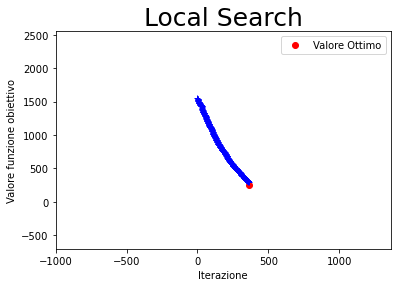

In [18]:
a=np.array(val_soluzioni)
l=len(a)
Best=Valore_Ottimo #Valore ottenuto dall' esecuzione dell'algoritmo esatto con Gurobi
plt.title("Local Search",fontsize=25)
plt.ylabel("Valore funzione obiettivo")
plt.xlabel("Iterazione")
plt.xlim(-num_colonne/2, l+num_colonne/2)
plt.ylim(min(a)-num_colonne/2, max(a)+num_colonne/2)
plt.plot([l-1],[Best], 'ro', label='Valore Ottimo')
for i in range(l):
    plt.plot([i],a[i],'b+')
plt.legend()

Definizione di una euristica di ricerca locale molto simile alla precedente, ma che implementa la ricerca nell'intorno con 
**tecnica FIRST IMPROVEMENT**. Verosimilmente dovrebbe verificarsi un calo nel tempo complessivo di calcolo della soluzione sub-ottima, con un conseguente (ma non certo) peggioramento del valore della soluzione finale.

In [19]:
def ricerca_locale_first_improvement(Sol,A,num_righe,num_colonne,costi_Sj,val_soluzioni,continua=True):
    
    vecchia_soluzione=Sol
    valore_sol = val_sol(Sol,costi_Sj)
    iter=0
    stessa_sol=0
    soluzioni=[]
    dim_intorno = int(0.1*num_colonne)

    while True:
        soluzioni_vicine = intorno(vecchia_soluzione,A,num_righe,num_colonne,costi_Sj,dim_intorno)
        migliore_sol=vecchia_soluzione
        val_migliore_sol = val_sol(vecchia_soluzione,costi_Sj)

        if continua and iter%50 == 0:
            print("iterazione N°:",iter, "--> Miglioramento Percentuale:", val_migliore_sol/valore_sol*100, "%")

        for sol,val in soluzioni_vicine:
            if(val < val_migliore_sol):
                val_migliore_sol = val
                migliore_sol = sol
                break
        
        if((migliore_sol == vecchia_soluzione).all()):
            stessa_sol = stessa_sol + 1
            if(stessa_sol == 100):
                break
        else:
            stessa_sol = 0
            vecchia_soluzione = migliore_sol

        iter = iter+1
    return vecchia_soluzione

In [20]:
#DEBUG
val_soluzioni=[]
t1=time.time()
Soluzione_Local_firts_improvement=ricerca_locale_first_improvement(Soluzione_Greedy,A,num_righe, num_colonne, costi_Sj,val_soluzioni)
t2=time.time()
print("Soluzione --> ",Soluzione_Local_firts_improvement,"\nValore soluzione: ",val_sol(Soluzione_Local_firts_improvement,costi_Sj))
print("Execution time Ricerca locale: ",t2-t1, "s")  

iterazione N°: 0 --> Miglioramento Percentuale: 100.0 %
iterazione N°: 50 --> Miglioramento Percentuale: 78.20760799484204 %
iterazione N°: 100 --> Miglioramento Percentuale: 55.89941972920697 %
iterazione N°: 150 --> Miglioramento Percentuale: 33.65570599613153 %
iterazione N°: 200 --> Miglioramento Percentuale: 29.851708575112827 %
iterazione N°: 250 --> Miglioramento Percentuale: 29.851708575112827 %
Soluzione -->  [0. 0. 0. ... 0. 0. 0.] 
Valore soluzione:  463.0
Execution time Ricerca locale:  3.1758289337158203 s


## <center> Euristica Tabu Search </center>

Classe coda_tabu per implementare il **TDA** per gestire le **mosse tabu**. L'elemento i-esimo della coda conterrà un intero rappresentante l'indice del subset Sj (nel vettore soluzione) che è stato oggetto di una mossa. Trattandosi di una **coda circolare** un determinato elemento non farà più parte della coda dopo dim_coda inserimenti. 

In [21]:
class coda_tabu:

    #dimensione = numero elementi contenuti
    def __init__(self, dimensione=5):
        self.coda = [None] * dimensione  #coda
        self.dimensione_max = dimensione
        self.punt_testa = 0 
        self.punt_coda = -1
        self.riemp = 0

    def inserisci_elemento_tabu(self, elem_tabu):
        self.punt_coda = (self.punt_coda + 1) % self.dimensione_max
        self.coda[self.punt_coda] = elem_tabu
        if(self.riemp!=self.dimensione_max):
            self.riemp = self.riemp + 1

    def trova_elemento(self, elem_tabu): 
        for i in range(self.riemp):
            if(self.coda[i] == elem_tabu):
                return True
        return False   

    def stampa_coda(self):
        print("Print Coda: ")
        for i in range(self.riemp):
            print(self.coda[i])
            
    def pulisci_tabu(self):
        for i in range(self.riemp):
            self.coda[i]=None
        self.riemp=0
        self.punt_testa = 0 
        self.punt_coda = -1

Codice di definizione dell'intorno per la **tabu search**. A differenza della procedura di calcolo dell'intorno per la ricerca locale standard, questa, nonostante generi indici casuali per determinare i subset da eliminare/aggiungere, effettua la mossa esclusivamente se l'indice del subset soggetto della mossa non si trova nella coda circolare tabu.

In [45]:
def intorno_tabu(Sol,A,num_colonne, costi_Sj,coda_tabu, dim_intorno, intensificazione):
    
    m=dim_intorno
    righe_coperte_base=np.zeros(num_righe)
    righe_coperte_base=copri_righe(Sol,A, num_righe,num_colonne)
    soluzioni_vicine=[]
    val_sol_iniziale=val_sol(Sol,costi_Sj)
    
    for i in range(m):
        k=np.random.randint(num_colonne)
        if(not(coda_tabu.trova_elemento(k)) and Sol[k]!=0):
            #print("k non è nella lista tabu!")
            new_sol=Sol.copy()
            elimina_set(new_sol,k)
            righe_coperte_delete=delete_righe_coperte(righe_coperte_base,k,A,num_righe)
            if(is_a_solution(righe_coperte_delete, num_righe)):
                new_val=val_sol_elimina(val_sol_iniziale,k,costi_Sj)
                soluzioni_vicine.append((new_sol,new_val,(k,-1)))
                            
    for i in range(m):
        k=np.random.randint(num_colonne)
        h=np.random.randint(num_colonne)
        if(not(coda_tabu.trova_elemento(h)) and not(coda_tabu.trova_elemento(k)) and Sol[h]!=0 and Sol[k]!=1):
            #print("h e k da swappare non sono nella lista tabu!")
            new_sol2=Sol.copy()
            scambia_set(new_sol2,h,k)
            righe_coperte_swap=swap_righe_coperte(righe_coperte_base,h,k,A,num_righe)
            if(is_a_solution(righe_coperte_swap, num_righe)):
                new_val=val_sol_swap(val_sol_iniziale,h,k,costi_Sj)
                soluzioni_vicine.append((new_sol2,new_val,(h,k)))
                
    if(intensificazione):
        
        for i in range(m):
            k1=np.random.randint(num_colonne)
            k2=np.random.randint(num_colonne)
            if(not(coda_tabu.trova_elemento(k1)) and not(coda_tabu.trova_elemento(k2)) and Sol[k1]==1 and Sol[k2]==1):
                new_sol=Sol.copy()
                elimina_set(new_sol,k1)
                elimina_set(new_sol,k2)
                righe_coperte_delete=delete_righe_coperte(righe_coperte_base,k1,A,num_righe)
                righe_coperte_delete=delete_righe_coperte(righe_coperte_delete,k2,A,num_righe)
                if(is_a_solution(righe_coperte_delete, num_righe)):
                    new_val=val_sol_elimina(val_sol_iniziale,k1,costi_Sj)
                    new_val=val_sol_elimina(new_val,k2,costi_Sj)
                    soluzioni_vicine.append((new_sol,new_val,(k1,k2)))
                else:   
                    h1=np.random.randint(num_colonne)
                    h2=np.random.randint(num_colonne)
                    if(not(coda_tabu.trova_elemento(h1)) and not(coda_tabu.trova_elemento(h2)) and Sol[h1]==0 and Sol[h2]==0):
                        new_sol=Sol.copy()
                        aggiungi_set(new_sol,h1)
                        aggiungi_set(new_sol,h2)
                        righe_coperte_add = add_righe_coperte(righe_coperte,h1,A,num_righe)
                        righe_coperte_add = add_righe_coperte(righe_coperte,h2,A,num_righe)
                        if(is_a_solution(righe_coperte_add, num_righe)):
                            new_val=val_sol_add(val_sol_iniziale,h1,costi_Sj)
                            new_val=val_sol_add(new_val,h2,costi_Sj)
                            soluzioni_vicine.append((new_sol,new_val,(h1,h2)))

    return soluzioni_vicine

Implementazione della Euristica Tabu Search. All'interno di tale implementazione si ritrovano i concetti di **intensificazione** (con l'aumento della dimensione e della popolosità dell'interno da ispezionare) e **diversificazione** (con la possibilità di effettuare delle iterazioni peggiorative

In [46]:
def tabu_search(Sol,A,num_colonne, costi_Sj,val_soluzioni,continua=True):
    
    vecchia_soluzione=Sol
    valore_sol = val_sol(Sol,costi_Sj)
    
    val_migliore_sol = valore_sol
    migliore_sol=Sol
    
    iter=0
    stessa_sol=0
    peggiora=False
    count_peggiora=0
    count_peggiorative_consecutive = 0
    
    intensifica = False
    
    dim_intorno = int(num_colonne*0.1)
    coda_tb=coda_tabu(int(num_colonne*0.06)) 
    
    #NOTA: Capacità della coda statica definita dalla dimensione del problema considerato. 
    #Rappresenta il numero di iterazioni dopo il quale la mossa tabu viene "sovrascritta" nella coda
    
    while True:
        soluzioni_vicine = intorno_tabu(vecchia_soluzione,A,num_colonne, costi_Sj, coda_tb, dim_intorno, intensifica)
        soluzione_attuale = vecchia_soluzione
        val_soluzione_attuale = val_sol(soluzione_attuale,costi_Sj)
        
        if continua and iter%50 == 0:
            print("Numero iterazione:", iter, "Scostamento percentuale: ",val_soluzione_attuale/valore_sol*100, "%")

        if(not peggiora):
            for sol,val,tabu in soluzioni_vicine:
               # print("sol , val",sol,val)
                if(val < val_soluzione_attuale):
                    #print("E' stata trovata una soluzione migliorativa con valore",val)
                    soluzione_attuale = sol
                    val_soluzione_attuale = val
                    if(val_soluzione_attuale < val_migliore_sol):
                        val_migliore_sol = val
                        migliore_sol = sol    
                        coda_tb.inserisci_elemento_tabu(tabu[0])
                        if(tabu[1]!=-1):
                            coda_tb.inserisci_elemento_tabu(tabu[1])
                        val_soluzioni.append(val)
        else:
            #print("Ricerca di una soluzione peggiorativa nell'intorno")
            for sol,val,tabu in soluzioni_vicine:
                if(val > val_soluzione_attuale):
                    print("Trovata soluzione peggiorativa nell'intorno con valore: ",val)
                    soluzione_attuale = sol
                    val_soluzione_attuale = val
                    val_soluzioni.append(val)
                    peggiora=False
                    break  
            

        if((soluzione_attuale == vecchia_soluzione).all()):
            stessa_sol = stessa_sol + 1
            
            if(stessa_sol==50): 
                #codatabu.pulisci_tabu()
                print("Trovata soluzione equivalente per 100 iterazioni consecutive")
                
                if(count_peggiora<3): 
                    
                    print("Effettuo una iterazione peggiorativa")
                    count_peggiora+=1
                    stessa_sol=0
                    peggiora=True
                    
                    #Anche qui viene applicata una tecnica di INTENSIFICAZIONE 
                    #Aumenta il numero di iterazioni nella determinazione dell'intorno
                    #ad ogni iterazione peggiorativa, in modo da infittire il numero 
                    #di soluzioni presenti in esso
                    dim_intorno += int(num_colonne*0.1)
                    
            elif(stessa_sol==100):
                print("Intensificazione, aumento l'ampiezza dell'intorno")
                if(peggiora):
                    peggiora = False
                intensificazione = True
                
            elif(stessa_sol==200):
                break
        else:
            stessa_sol = 0
            vecchia_soluzione = soluzione_attuale

        iter = iter+1
    return migliore_sol

In [47]:
val_soluzioni2 = []
soluzione = np.ones(num_colonne)
t1=time.time()
Soluzione_tabu=tabu_search(Soluzione_Greedy,A,num_colonne,costi_Sj,val_soluzioni2)
t2=time.time()
print("Soluzione : ",Soluzione_tabu,"\nValore soluzione: ",val_sol(Soluzione_tabu,costi_Sj),"\nExecution time Tabu Search:",t2-t1," s")

Numero iterazione: 0 Scostamento percentuale:  100.0 %
Numero iterazione: 50 Scostamento percentuale:  60.21921341070278 %
Numero iterazione: 100 Scostamento percentuale:  35.84784010315925 %
Numero iterazione: 150 Scostamento percentuale:  25.85428755641522 %
Numero iterazione: 200 Scostamento percentuale:  25.78981302385558 %
Trovata soluzione equivalente per 100 iterazioni consecutive
Effettuo una iterazione peggiorativa
Trovata soluzione peggiorativa nell'intorno con valore:  453.0
Numero iterazione: 250 Scostamento percentuale:  28.755641521598967 %
Trovata soluzione equivalente per 100 iterazioni consecutive
Effettuo una iterazione peggiorativa
Trovata soluzione peggiorativa nell'intorno con valore:  459.0
Numero iterazione: 300 Scostamento percentuale:  29.593810444874276 %
Trovata soluzione equivalente per 100 iterazioni consecutive
Effettuo una iterazione peggiorativa
Trovata soluzione peggiorativa nell'intorno con valore:  505.0
Numero iterazione: 350 Scostamento percentuale:

KeyboardInterrupt: 

In [ ]:
a=np.array(val_soluzioni2)
l=len(a)
Best=Valore_Ottimo #Valore ottenuto dall' esecuzione dell'algoritmo esatto con Gurobi
plt.title("Tabu Search",fontsize=25)
plt.ylabel("Valore funzione obiettivo")
plt.xlabel("Iterazione")
plt.xlim(-num_colonne/4, l+num_colonne/4)
plt.ylim(min(a)-num_colonne/4, max(a)+num_colonne/4)
plt.plot([l-1],[Best], 'ro', label='Valore Ottimo')
for i in range(l):
    plt.plot([i],a[i],'b+')
plt.legend()